In [4]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


In [5]:
import torch
import torchaudio
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import random
#from plot_audio import plot_specgram, plot_waveform
os.getcwd()

'/Users/jansta/learn/acoustics'

In [6]:
dict_mats = np.load('/Users/jansta/learn/acoustics/dict_mats.npy', allow_pickle=True).item()


In [7]:
# t = dict_mats['A']['can_opening'][2]


# print(t.shape)
# t2 = t / t.max()

# print(np.max(t), np.min(t), np.mean(t), np.std(t))
# #plt.plot(t)
# plt.hist(t, bins=100)




In [8]:
len(dict_mats['A']['can_opening'][3])

all_labels = dict_mats['A'].keys()
print(all_labels)

dict_keys(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train', 'sheep', 'water_drops', 'church_bells', 'clock_alarm', 'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow', 'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter', 'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine', 'breathing', 'crying_baby', 'hand_saw', 'coughing', 'glass_breaking', 'snoring', 'toilet_flush', 'pig', 'washing_machine', 'clock_tick', 'sneezing', 'rooster', 'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'])


In [9]:
chosen_labels = ['crickets', 'can_opening', 'chirping_birds', 'dog', 'chainsaw'][:4]
encoded_labels = {'crickets': 0, 'can_opening': 1, 'chirping_birds': 2, 'dog': 3, 'chainsaw': 4}

In [10]:
chosen_labels = list(all_labels)[16:26]

encoded_labels = {}
for i, label in enumerate(chosen_labels):
    encoded_labels[label] = i

In [11]:
class AudioDataset(Dataset):
    def __init__(self, dict_mats, chosen_labels, encoded_labels, transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        for key in dict_mats.keys():
            if key in chosen_labels:
                for i in range(len(dict_mats[key])):
                    self.X.append(dict_mats[key][i])
                    self.y.append(encoded_labels[key])
        
        self.X = np.array(self.X)
        self.y = np.array(self.y)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        
        # Add a channel dimension
        sample = np.expand_dims(sample, axis=0)
        
        # Convert to tensor
        sample = torch.FloatTensor(sample)
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, label

In [12]:
transform = transforms.Compose(
    [transforms.Resize((64,431)),
    transforms.Grayscale(num_output_channels=1),
    #transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
    ])

In [13]:
# Create dataset with transform
dataset = AudioDataset(dict_mats['A'], chosen_labels, encoded_labels, transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [14]:
# Test the dataloader
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"Input batch size: {inputs.size()}")
    print(f"Labels: {labels}")
    print("-" * 30)
    break  # Just to test the first batch

Batch 1:
Input batch size: torch.Size([4, 1, 64, 431])
Labels: tensor([7, 0, 6, 2])
------------------------------


In [15]:
n_classes = len(chosen_labels)

class AudioClassifNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        #self.fc1 = nn.Linear(64 * 4 * 53, 256)  # Adjusted based on pooling layers
        self.fc1 = nn.Linear(64 * 4 * 26, 256)  # Adjusted based on pooling layers
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_classes)  # classes
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)  # out: (BS, 16, 64, 431)
        x = self.relu(x)
        x = self.pool(x)   # out: (BS, 16, 32, 215)
        x = self.conv2(x)  # out: (BS, 32, 32, 215)
        x = self.relu(x)
        x = self.pool(x)   # out: (BS, 32, 16, 107)
        x = self.conv3(x)  # out: (BS, 64, 8, 107)
        x = self.relu(x)
        x = self.pool(x)   # out: (BS, 64, 8, 53)
        x = self.pool(x)   # additional pooling layer - out: (BS, 64, 4, 26) 
        x = self.flatten(x) # out: (4, 3328)
        x = self.fc1(x)  # out: (BS, 256)
        x = self.relu(x)
        x = self.fc2(x)  # out: (BS, 128)
        x = self.relu(x)
        x = self.fc3(x)  # out: (BS, n_classes)
        x = self.softmax(x)
        return x

In [16]:
def check_for_nans(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaNs found in {name}")
        return True
    return False



In [17]:
## Create an  instance of the model:
model = AudioClassifNet()

Epoch 0/500, Loss: 2.396928
Epoch 10/500, Loss: 0.686577
Epoch 20/500, Loss: 0.105382
Epoch 30/500, Loss: 0.024344
Epoch 40/500, Loss: 0.012364
Epoch 50/500, Loss: 0.056210
Epoch 60/500, Loss: 0.010704
Epoch 70/500, Loss: 0.002817
Epoch 80/500, Loss: 0.234122
Epoch 90/500, Loss: 0.007818
Epoch 100/500, Loss: 0.016213
Epoch 110/500, Loss: 0.000894
Epoch 120/500, Loss: 0.000195
Epoch 130/500, Loss: 0.000079
Epoch 140/500, Loss: 0.000041
Epoch 150/500, Loss: 0.000019
Epoch 160/500, Loss: 0.000011
Epoch 170/500, Loss: 0.000006
Epoch 180/500, Loss: 0.000003
Epoch 190/500, Loss: 0.000002
Epoch 200/500, Loss: 0.000001
Epoch 210/500, Loss: 0.000001
Epoch 220/500, Loss: 0.000001
Epoch 230/500, Loss: 0.000000
Epoch 240/500, Loss: 0.000000
Epoch 250/500, Loss: 0.000000
Epoch 260/500, Loss: 0.000000
Epoch 270/500, Loss: 0.000000
Epoch 280/500, Loss: 0.000000
Epoch 290/500, Loss: 0.000000
Epoch 300/500, Loss: 0.000000
Epoch 310/500, Loss: 0.000000
Epoch 320/500, Loss: 0.000000
Epoch 330/500, Loss: 

<Axes: >

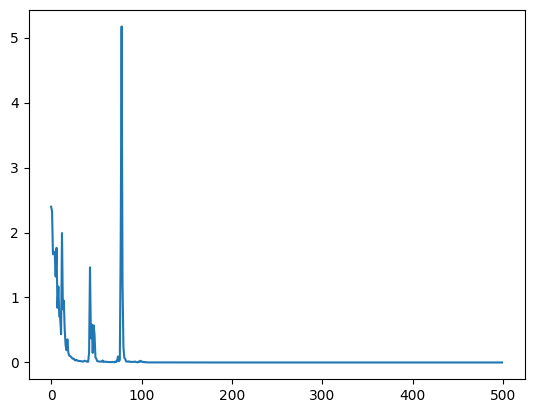

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# %% TRAINING
losses_epoch_mean = []
NUM_EPOCHS = 500
for epoch in range(NUM_EPOCHS):
    losses_epoch = []
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # Check for NaN loss
        if torch.isnan(inputs).any():
            print(f"NaN input at epoch {epoch}, batch {i}")

            i_err = inputs
            break
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Check for NaN loss
        if torch.isnan(loss):
            print(f"NaN loss at epoch {epoch}, batch {i}")
            l_err = loss
            break
        
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        losses_epoch.append(loss.item())
    
    # if torch.isnan(loss):
    #     break
    
    losses_epoch_mean.append(np.mean(losses_epoch))
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{NUM_EPOCHS}, Loss: {np.mean(losses_epoch):.6f}')

sns.lineplot(x=list(range(len(losses_epoch_mean))), y=losses_epoch_mean)        

In [ ]:
y_val = []
y_val_hat = []
for i, data in enumerate(val_loader):
    inputs, y_val_temp = data
    with torch.no_grad():
        y_val_hat_temp = model(inputs).round()
    
    y_val.extend(y_val_temp.numpy())
    y_val_hat.extend(y_val_hat_temp.numpy())

In [ ]:

# Accuracy
acc = accuracy_score(y_val, np.argmax(y_val_hat, axis=1))
print(f'Accuracy: {acc*100:.2f} %')
# confusion matrix
cm = confusion_matrix(y_val, np.argmax(y_val_hat, axis=1))
sns.heatmap(cm, annot=True, xticklabels=chosen_labels, yticklabels=chosen_labels)


In [21]:
torch.save(model.state_dict(), 'audio_classification_model.pth')